In [131]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from PIL import Image
import joblib
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

In [132]:
df=pd.read_csv("diabetes-dataset.csv")

About Dataset
Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

Content
Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

Pregnancies: Number of times pregnant
Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
BloodPressure: Diastolic blood pressure (mm Hg)
SkinThickness: Triceps skin fold thickness (mm)
Insulin: 2-Hour serum insulin (mu U/ml)
BMI: Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction: Diabetes pedigree function
Age: Age (years)
Outcome: Class variable (0 or 1)

Sources:
(a) Original owners: National Institute of Diabetes and Digestive and
Kidney Diseases
(b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
Research Center, RMI Group Leader
Applied Physics Laboratory
The Johns Hopkins University
Johns Hopkins Road
Laurel, MD 20707
(301) 953-6231
(c) Date received: 9 May 1990

In [133]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [134]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [135]:
df.shape

(768, 9)

In [136]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [138]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [139]:
df.duplicated().sum()

np.int64(0)

<Axes: >

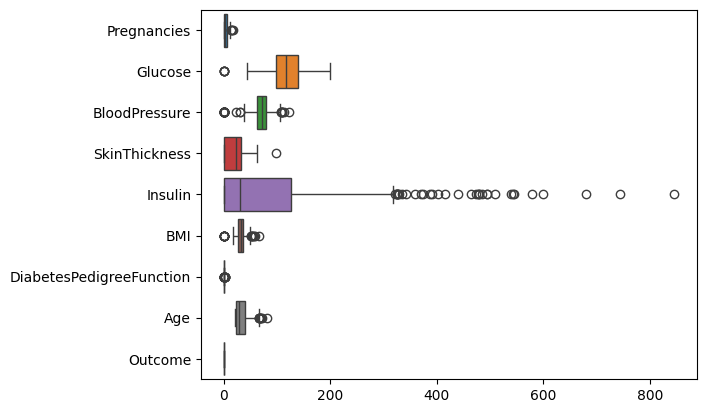

In [140]:
sns.boxplot(data=df, orient="h")

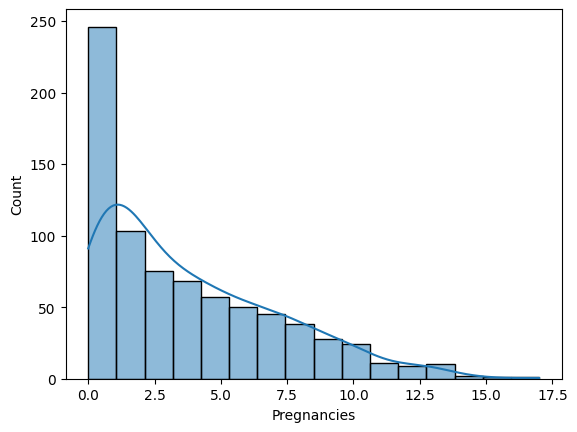

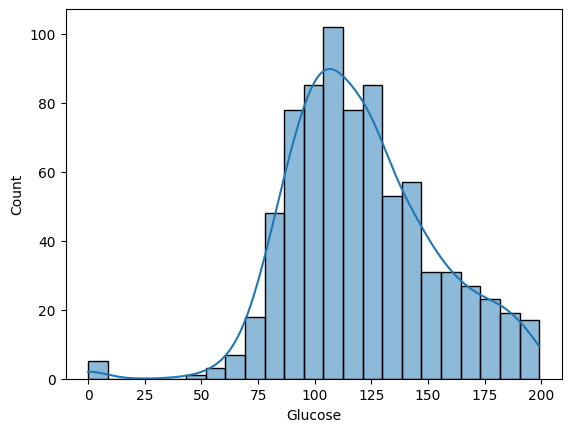

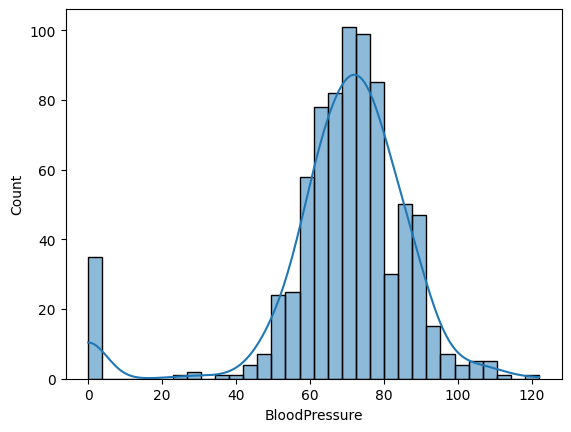

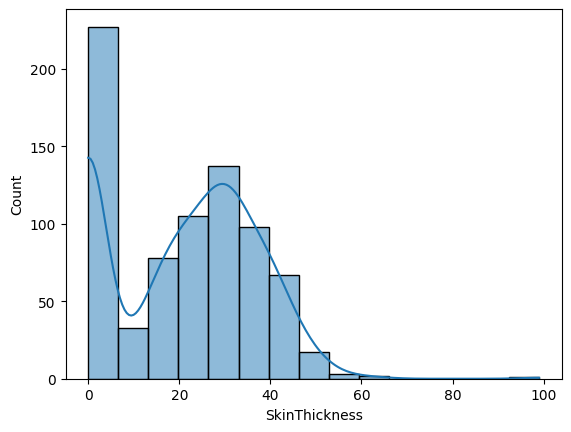

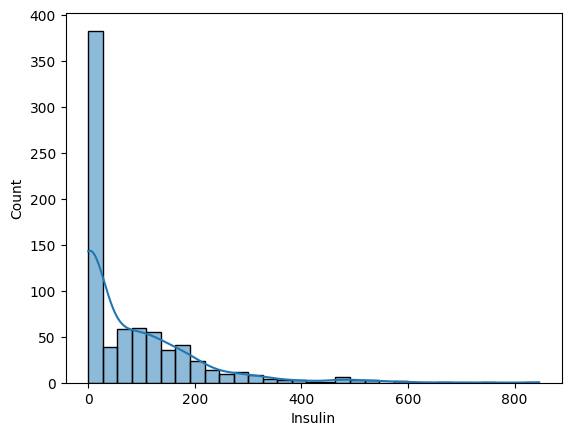

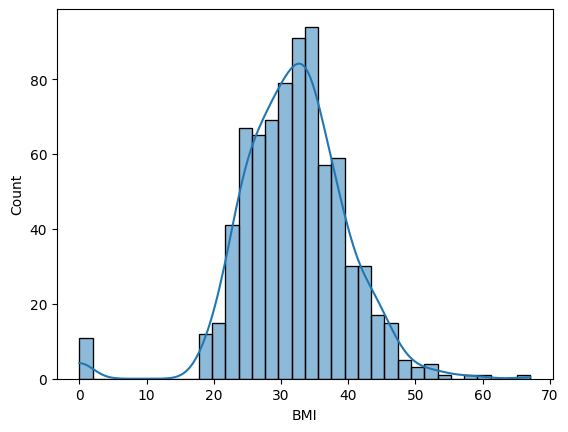

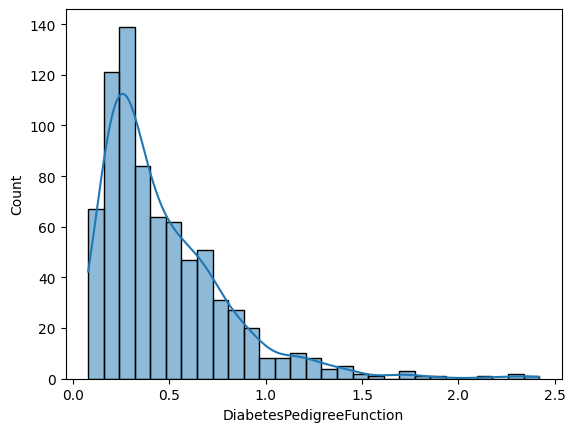

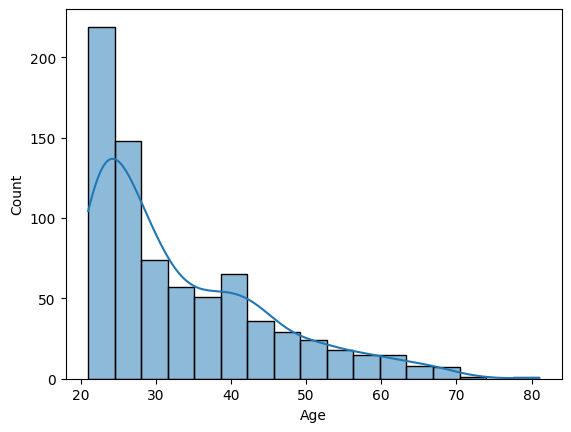

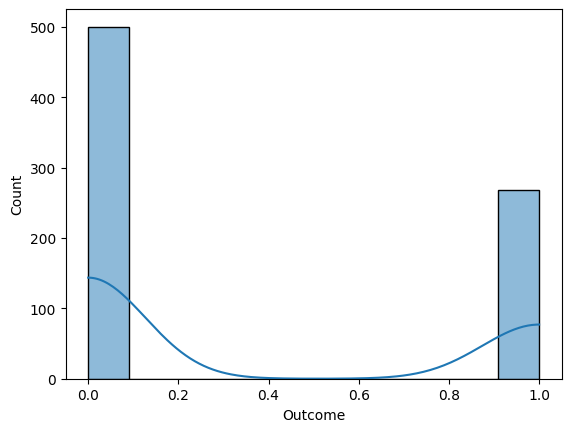

In [141]:
for col in df.columns:
    sns.histplot(data=df, x=col, kde=True)
    plt.show()

In [142]:
#Finding columns with outliers

def cols_with_outliers(df, cols, lower_threshold=0.25, upper_threshold=0.75):
    outlier_cols=[]
    for col in cols:
        q1=df[col].quantile(lower_threshold)
        q3=df[col].quantile(upper_threshold)
        interquantile_range=q3-q1
        upper_limit=q3+1.5*interquantile_range
        low_limit=q1-1.5*interquantile_range
        if df[(df[col]>upper_limit) | (df[col]<low_limit)].any(axis=None):  #checks at lease one value is in the filtered df, axis=None -> search across the entire df(all rows and cols)
            outlier_cols.append(col)
        if not outlier_cols:
            print("There is no outliers")
        return outlier_cols

In [143]:
outlier_cols=cols_with_outliers(df,df.columns)

In [144]:
outlier_cols

['Pregnancies']

In [145]:
def replace_with_thresholds(df,col, lower_threshold=0.25, upper_threshold=0.75):
    q1=df[col].quantile(lower_threshold)
    q3=df[col].quantile(upper_threshold)
    interquantile_range=q3-q1
    upper_limit=q3+1.5*interquantile_range
    low_limit=q1-1.5*interquantile_range
    df.loc[df[col]<low_limit,col]=low_limit #uses .loc to find all rows in df[col] where values are below the low_limit and replaces them with low_limit
    df.loc[df[col]>upper_limit,col]=upper_limit #uses .loc to find all rows in df[col] where values are above the upper_limit and replaces them with upper_limit

In [146]:
for col in outlier_cols:
    replace_with_thresholds(df,col)

C:\Users\Max\AppData\Local\Temp\ipykernel_22028\2863642122.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[col]<low_limit,col]=low_limit #uses .loc to find all rows in df[col] where values are below the low_limit and replaces them with low_limit


In [147]:
outlier_cols=cols_with_outliers(df,df.columns)

There is no outliers


<Axes: >

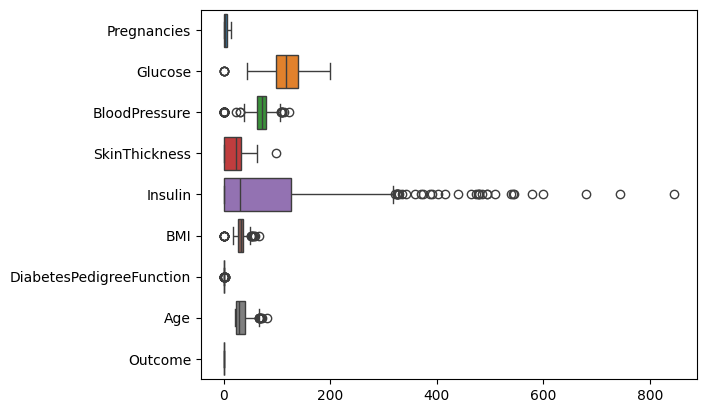

In [148]:
sns.boxplot(data=df, orient="h")

<Axes: >

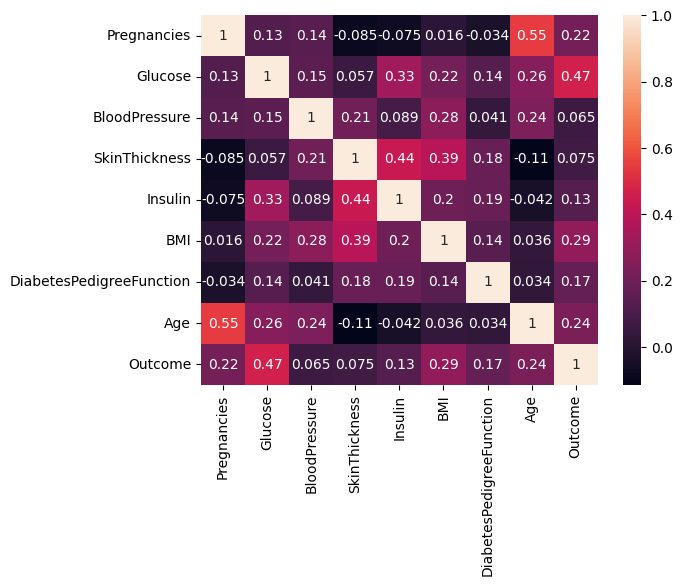

In [149]:
sns.heatmap(df.corr(),annot=True)

There are no highly correlated attributes

Text(0.5, 1.0, 'Outcome Distribution')

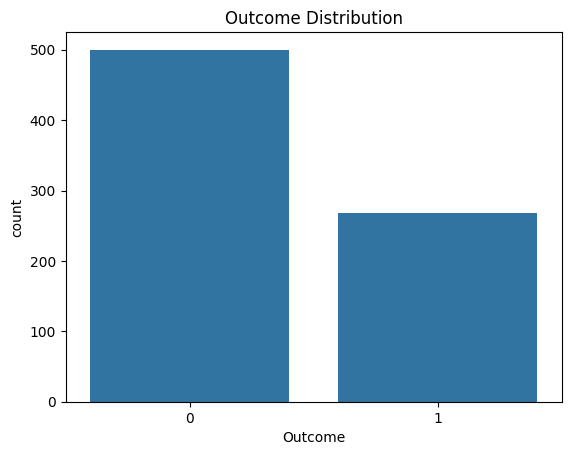

In [150]:
sns.barplot(data=df["Outcome"].value_counts()).set_title("Outcome Distribution")

In [151]:
df['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Target variable vs attributes

In [152]:
for col in df.columns:
    print(df.groupby("Outcome").agg({col:"mean"}),"\n")

         Pregnancies
Outcome             
0           3.298000
1           4.843284 

            Glucose
Outcome            
0        109.980000
1        141.257463 

         BloodPressure
Outcome               
0            68.184000
1            70.824627 

         SkinThickness
Outcome               
0            19.664000
1            22.164179 

            Insulin
Outcome            
0         68.792000
1        100.335821 

               BMI
Outcome           
0        30.304200
1        35.142537 

         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500 

               Age
Outcome           
0        31.190000
1        37.067164 

         Outcome
Outcome         
0            0.0
1            1.0 



The probability of having Diabetes is higher when Insulin and Glucose levels are high.

In [153]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [154]:
cols_for_scaling=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

In [155]:
sc=MinMaxScaler()

In [156]:
min_max_vals={}
for col in cols_for_scaling:
    min_val=df[col].min()
    max_val=df[col].max()
    min_max_vals[col]=(min_val,max_val)

joblib.dump(min_max_vals,"min_max_vals.joblib")
print("min_max_vals dump file saved.")

min_max_vals dump file saved.


In [157]:
for col in cols_for_scaling:
    df[col]=sc.fit_transform(df[[col]])

In [158]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.444444,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.074074,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.592593,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.074074,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
5,0.370370,0.582915,0.606557,0.000000,0.000000,0.381520,0.052519,0.150000,0
6,0.222222,0.391960,0.409836,0.323232,0.104019,0.461997,0.072588,0.083333,1
7,0.740741,0.577889,0.000000,0.000000,0.000000,0.526080,0.023911,0.133333,0
8,0.148148,0.989950,0.573770,0.454545,0.641844,0.454545,0.034159,0.533333,1
9,0.592593,0.628141,0.786885,0.000000,0.000000,0.000000,0.065756,0.550000,1


In [159]:
df['Outcome'].astype(int)

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [160]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.444444,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.074074,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.592593,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.074074,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
5,0.370370,0.582915,0.606557,0.000000,0.000000,0.381520,0.052519,0.150000,0
6,0.222222,0.391960,0.409836,0.323232,0.104019,0.461997,0.072588,0.083333,1
7,0.740741,0.577889,0.000000,0.000000,0.000000,0.526080,0.023911,0.133333,0
8,0.148148,0.989950,0.573770,0.454545,0.641844,0.454545,0.034159,0.533333,1
9,0.592593,0.628141,0.786885,0.000000,0.000000,0.000000,0.065756,0.550000,1


In [161]:
y=df['Outcome']
X=df.drop(['Outcome'],axis=1)

In [162]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

* We use following models for predicting the Diabetes 
    * Logistic Regression - Uses Sigmoid function to model predictions and probabilities.
    * Random Forest Classifier - Creates multiple Decision Trees using different random subsets of data and features.
    * K-neighbors Classifier - Assumes the similarity between the new obsesrvations and the existing cases and put the new case into the category which is most similar to the available category.
    * Support Vector Classifier - Try to find the best hyperplane which separates two classes. Uses statistical approach.
    * Gradient Boosting Classifier - Combines the predictions of multiple weaker learners to create a single more accurate learner.
    * XGB Classifier - Uses Decision Trees as base learners and applies regularization techniques to enhance model genaralization.

In [163]:
models=[
    ("LR",LogisticRegression()),
    ("RF",RandomForestClassifier()),
    ("KNN",KNeighborsClassifier()),
    ("SVC",SVC()),
    ("GB",GradientBoostingClassifier()),
    ("XGB",XGBClassifier()),
]

In [164]:
for name,regressor in models:
    cv=cross_validate(regressor,X,y,cv=5,scoring=["accuracy","f1","recall","precision"])
    print(f'{name} \n {"Accuracy"}:{cv["test_accuracy"].mean()} \n {"Recall"}:{cv["test_recall"].mean()} \n {"Precision"}:{cv["test_precision"].mean()} \n {"F-Score"}:{cv["test_f1"].mean()}')

LR 
 Accuracy:0.7643663526016466 
 Recall:0.5075471698113208 
 Precision:0.7389810078762733 
 F-Score:0.6008024953555324
RF 
 Accuracy:0.7774127832951363 
 Recall:0.5934311670160727 
 Precision:0.7255394369224157 
 F-Score:0.6500604786118785
KNN 
 Accuracy:0.7422205245734658 
 Recall:0.5485674353598882 
 Precision:0.6576434676434676 
 F-Score:0.5971252613957329
SVC 
 Accuracy:0.770902300314065 
 Recall:0.5524109014675053 
 Precision:0.7308539205155746 
 F-Score:0.6274437473002978
GB 
 Accuracy:0.7604702487055428 
 Recall:0.6046820405310971 
 Precision:0.6759148936170212 
 F-Score:0.6367750111908143
XGB 
 Accuracy:0.7409557762498938 
 Recall:0.6046820405310972 
 Precision:0.6362595468391298 
 F-Score:0.6180796532975465


In [165]:
sm=SMOTE()

In [166]:
sum(y_train==1)

221

In [167]:
sum(y_train==0)

393

In [168]:
X_train_smote,y_train_smote=sm.fit_resample(X_train,y_train)

In [169]:
sum(y_train_smote==1)

393

In [170]:
sum(y_train_smote==0)

393

In [171]:
for name,regressor in models:
    cv=cross_validate(regressor,X_train_smote,y_train_smote,cv=5,scoring=["accuracy","f1","recall","precision"])
    print(f'{name} \n {"Accuracy"}:{cv["test_accuracy"].mean()} \n {"Recall"}:{cv["test_recall"].mean()} \n {"Precision"}:{cv["test_precision"].mean()} \n {"F-Score"}:{cv["test_f1"].mean()}')

LR 
 Accuracy:0.7404095783278241 
 Recall:0.7073677377474846 
 Precision:0.7587800459479217 
 F-Score:0.7312372762333499
RF 
 Accuracy:0.8117068451181165 
 Recall:0.8365790327815643 
 Precision:0.7938225747743263 
 F-Score:0.8137252813457577
KNN 
 Accuracy:0.7391679432395387 
 Recall:0.8138591366439467 
 Precision:0.7072192513368984 
 F-Score:0.7560215330020853
SVC 
 Accuracy:0.7340562767072483 
 Recall:0.7300876338851022 
 Precision:0.7353317698561602 
 F-Score:0.732500765546174
GB 
 Accuracy:0.7900669192937193 
 Recall:0.8034728984096073 
 Precision:0.7790390137246122 
 F-Score:0.7899942842371249
XGB 
 Accuracy:0.7913569297750543 
 Recall:0.8161635832521907 
 Precision:0.7738324323430706 
 F-Score:0.7929100975461261


In [172]:
model=RandomForestClassifier()
model.fit(X_train_smote,y_train_smote)

RandomForestClassifier()

In [173]:
#saving the model
with open("DiaModel.pkl","wb") as f:
    pickle.dump(model,f)

print("model saved successfully")

model saved successfully
